<a href="https://colab.research.google.com/github/ManapatWeeramongkolkul/ForestFireML/blob/main/KMUTNB_Workshop_Prerequisite.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Libraries

In [ ]:
!pip install pyspark
!pip install matplotlib seaborn openpyxl pandas shap

In [ ]:
# Common Libraries
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np

# Spark Libraries
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, to_date, datediff

# ML Model
import lightgbm as lgb
import shap
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

## Initializing Spark Session

In [ ]:
spark = SparkSession.builder.appName("PySparkWorkshop").getOrCreate()

# Import Data

In [ ]:
file_path = "/content/Price_SampleDataset.xlsx"
pandas_df = pd.read_excel(file_path)
data = spark.createDataFrame(pandas_df)

In [ ]:
data.printSchema()

root
 |-- #: long (nullable = true)
 |-- ADR_USD: double (nullable = true)
 |-- hotel_id: long (nullable = true)
 |-- star_rating: double (nullable = true)
 |-- accommodation_type_name: string (nullable = true)
 |-- chain_hotel: string (nullable = true)
 |-- booking_date: timestamp (nullable = true)
 |-- checkin_date: timestamp (nullable = true)
 |-- checkout_date: timestamp (nullable = true)
 |-- city: string (nullable = true)



In [ ]:
data.show(5)

+---+-------+--------+-----------+-----------------------+-----------+-------------------+-------------------+-------------------+----+
|  #|ADR_USD|hotel_id|star_rating|accommodation_type_name|chain_hotel|       booking_date|       checkin_date|      checkout_date|city|
+---+-------+--------+-----------+-----------------------+-----------+-------------------+-------------------+-------------------+----+
|  1|  71.06|  297388|        2.5|                  Hotel|  non-chain|2016-08-02 00:00:00|2016-10-01 00:00:00|2016-10-02 00:00:00|   A|
|  2|  76.56|  298322|        3.0|                  Hotel|  non-chain|2016-08-02 00:00:00|2016-10-01 00:00:00|2016-10-02 00:00:00|   A|
|  3| 153.88| 2313076|        5.0|                  Hotel|      chain|2016-08-02 00:00:00|2016-10-01 00:00:00|2016-10-02 00:00:00|   A|
|  4|  126.6| 2240838|        3.5|                  Hotel|  non-chain|2016-08-04 00:00:00|2016-10-02 00:00:00|2016-10-03 00:00:00|   A|
|  5| 115.08| 2240838|        3.5|              

In [ ]:
print("Number of rows:", data.count())
print("Number of columns:", len(data.columns))
data.describe().show()

Number of rows: 27298
Number of columns: 10
+-------+-----------------+------------------+-----------------+------------------+-----------------------+-----------+-----+
|summary|                #|           ADR_USD|         hotel_id|       star_rating|accommodation_type_name|chain_hotel| city|
+-------+-----------------+------------------+-----------------+------------------+-----------------------+-----------+-----+
|  count|            27298|             27298|            27298|             27298|                  27298|      27298|27298|
|   mean|          13649.5|103.72624774214553|703581.0592717415|3.5205143233936553|                   NULL|       NULL| NULL|
| stddev|7880.398160414654| 83.21099679408057|711981.7060026889|0.8669716334032895|                   NULL|       NULL| NULL|
|    min|                1|              4.26|              770|               0.0|              Apartment|      chain|    A|
|    max|            27298|           2326.24|          4525158|          

In [ ]:
data = data.withColumn("leadtime", datediff(col("checkin_date"), col("booking_date")))
data = data.withColumn("los", datediff(col("checkout_date"), col("checkin_date")))

In [ ]:
data.show(5)

+---+-------+--------+-----------+-----------------------+-----------+-------------------+-------------------+-------------------+----+--------+---+
|  #|ADR_USD|hotel_id|star_rating|accommodation_type_name|chain_hotel|       booking_date|       checkin_date|      checkout_date|city|leadtime|los|
+---+-------+--------+-----------+-----------------------+-----------+-------------------+-------------------+-------------------+----+--------+---+
|  1|  71.06|  297388|        2.5|                  Hotel|  non-chain|2016-08-02 00:00:00|2016-10-01 00:00:00|2016-10-02 00:00:00|   A|      60|  1|
|  2|  76.56|  298322|        3.0|                  Hotel|  non-chain|2016-08-02 00:00:00|2016-10-01 00:00:00|2016-10-02 00:00:00|   A|      60|  1|
|  3| 153.88| 2313076|        5.0|                  Hotel|      chain|2016-08-02 00:00:00|2016-10-01 00:00:00|2016-10-02 00:00:00|   A|      60|  1|
|  4|  126.6| 2240838|        3.5|                  Hotel|  non-chain|2016-08-04 00:00:00|2016-10-02 00:00

## Convert Spark to Pandas

*   Here we're converting Spark back to Pandas since we've created new columns
*   Some people will recommend to NOT use toPandas()

https://stackoverflow.com/questions/75575544/why-topandas-is-bad

https://stackoverflow.com/questions/29226210/what-is-the-spark-dataframe-method-topandas-actually-doing


*   What do you think are the solutions to this? 🤔



In [ ]:
pandas_df = data.toPandas()

### Answer



1.   Just use less data
2.   Use Spark native libraries for your work



### Data Cleaning and Visualization

In [ ]:
pandas_df.dtypes

,0
#,int64
ADR_USD,float64
hotel_id,int64
star_rating,float64
accommodation_type_name,object
chain_hotel,object
booking_date,datetime64[ns]
checkin_date,datetime64[ns]
checkout_date,datetime64[ns]
city,object


In [ ]:
pandas_df.head(5)

,#,ADR_USD,hotel_id,star_rating,accommodation_type_name,chain_hotel,booking_date,checkin_date,checkout_date,city,leadtime,los
0,1,71.06,297388,2.5,Hotel,non-chain,2016-08-02,2016-10-01,2016-10-02,A,60,1
1,2,76.56,298322,3.0,Hotel,non-chain,2016-08-02,2016-10-01,2016-10-02,A,60,1
2,3,153.88,2313076,5.0,Hotel,chain,2016-08-02,2016-10-01,2016-10-02,A,60,1
3,4,126.60,2240838,3.5,Hotel,non-chain,2016-08-04,2016-10-02,2016-10-03,A,59,1
4,5,115.08,2240838,3.5,Hotel,non-chain,2016-08-04,2016-10-02,2016-10-03,A,59,1


In [ ]:
pandas_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27298 entries, 0 to 27297
Data columns (total 12 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   #                        27298 non-null  int64         
 1   ADR_USD                  27298 non-null  float64       
 2   hotel_id                 27298 non-null  int64         
 3   star_rating              27298 non-null  float64       
 4   accommodation_type_name  27298 non-null  object        
 5   chain_hotel              27298 non-null  object        
 6   booking_date             27298 non-null  datetime64[ns]
 7   checkin_date             27298 non-null  datetime64[ns]
 8   checkout_date            27298 non-null  datetime64[ns]
 9   city                     27298 non-null  object        
 10  leadtime                 27298 non-null  int32         
 11  los                      27298 non-null  int32         
dtypes: datetime64[ns](3), float64(2)

In [ ]:
pandas_df.describe().round(1)

,#,ADR_USD,hotel_id,star_rating,booking_date,checkin_date,checkout_date,leadtime,los
count,27298.0,27298.0,27298.0,27298.0,27298,27298,27298,27298.0,27298.0
mean,13649.5,103.7,703581.1,3.5,2016-11-03 05:15:39.761154560,2016-11-16 14:20:19.078320640,2016-11-18 06:30:18.331013632,13.4,1.7
min,1.0,4.3,770.0,0.0,2016-08-02 00:00:00,2016-10-01 00:00:00,2016-10-02 00:00:00,-1.0,1.0
25%,6825.2,52.6,197996.0,3.0,2016-10-11 00:00:00,2016-10-24 00:00:00,2016-10-26 00:00:00,1.0,1.0
50%,13649.5,82.9,475584.0,3.5,2016-11-04 00:00:00,2016-11-17 00:00:00,2016-11-19 00:00:00,7.0,1.0
75%,20473.8,129.6,866630.0,4.0,2016-11-27 00:00:00,2016-12-10 00:00:00,2016-12-12 00:00:00,21.0,2.0
max,27298.0,2326.2,4525158.0,5.0,2016-12-31 00:00:00,2016-12-31 00:00:00,2017-01-03 00:00:00,60.0,3.0
std,7880.4,83.2,711981.7,0.9,NaN,NaN,NaN,15.3,0.8


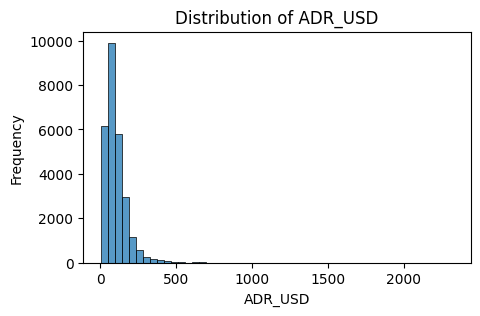

In [ ]:
plt.figure(figsize=(5, 3))
sns.histplot(pandas_df["ADR_USD"], bins=50)
plt.title("Distribution of ADR_USD")
plt.xlabel("ADR_USD")
plt.ylabel("Frequency")
plt.show()

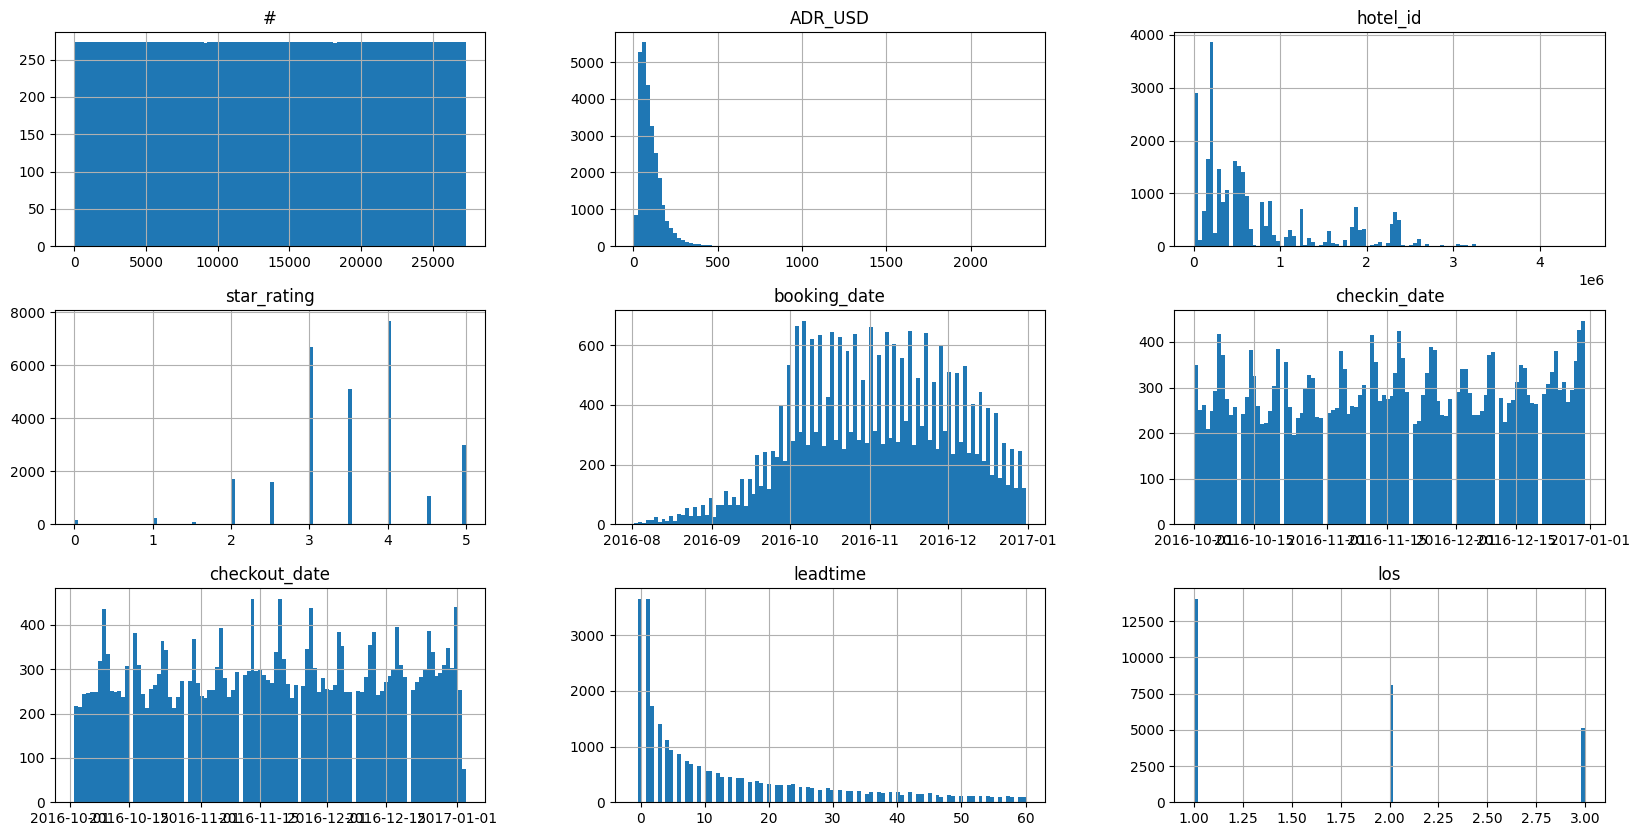

In [ ]:
pandas_df.hist(bins=100, figsize = (20,10))
plt.show()

# ML Model (Pandas)

In [ ]:
numerical_features = ["star_rating", "leadtime", "los"]
# hotel_id is an identifier so should not be included
categorical_features = ["accommodation_type_name", "chain_hotel", "city"]
features = numerical_features + categorical_features
print(features)

target = "ADR_USD"

['star_rating', 'leadtime', 'los', 'accommodation_type_name', 'chain_hotel', 'city']


In [ ]:
pandas_df[categorical_features] = pandas_df[categorical_features].astype("category")
pandas_df[numerical_features] = pandas_df[numerical_features].astype("float")

In [ ]:
pandas_df.dtypes

,0
#,int64
ADR_USD,float64
hotel_id,int64
star_rating,float64
accommodation_type_name,category
chain_hotel,category
booking_date,datetime64[ns]
checkin_date,datetime64[ns]
checkout_date,datetime64[ns]
city,category


### Train-Test Split

In [ ]:
X = pandas_df[features]
y = pandas_df[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### Model Training

In [ ]:
train_data = lgb.Dataset(X_train, label=y_train, categorical_feature=categorical_features)
test_data = lgb.Dataset(X_test, label=y_test, categorical_feature=categorical_features, reference=train_data)

params = {
    "objective": "regression",
    "metric": "rmse",
    "boosting_type": "gbdt",
    "learning_rate": 0.1,
    "num_leaves": 31,
    "max_depth": -1,
    "verbose": 1
}

model = lgb.train(params, train_data, valid_sets=[train_data, test_data], num_boost_round=1000)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.054432 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 94
[LightGBM] [Info] Number of data points in the train set: 21838, number of used features: 6
[LightGBM] [Info] Start training from score 103.894162


### Model Testing

In [ ]:
y_pred = model.predict(X_test, num_iteration=model.best_iteration)

In [ ]:
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

evaluation_metrics = pd.DataFrame({
    "Metric": ["MSE","RMSE","MAE", "R² Score"],
    "Value": [mse, rmse, mae, r2]
})
display(evaluation_metrics)

,Metric,Value
0,MSE,3763.266888
1,RMSE,61.345472
2,MAE,31.647147
3,R² Score,0.392869


### Feature Importance

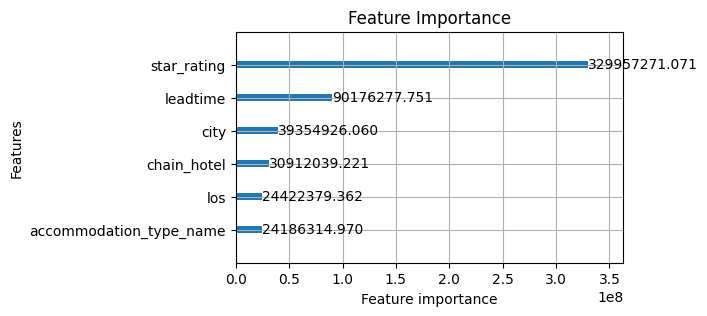

In [ ]:
lgb.plot_importance(model, max_num_features=10, importance_type="gain", figsize=(5, 3))
plt.title("Feature Importance")
plt.show()

### SHAP Explainer

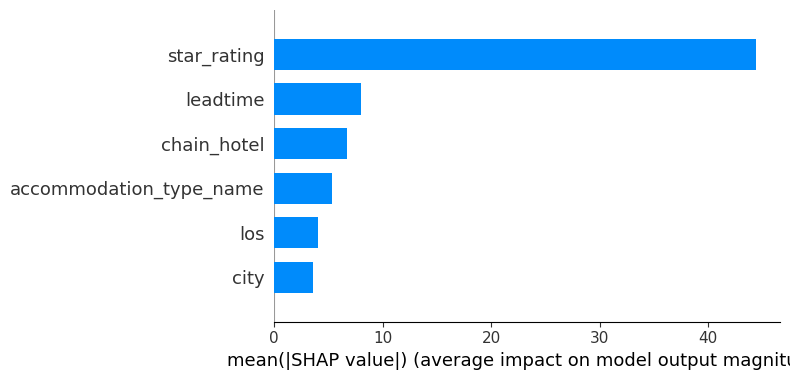

In [ ]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test)
shap.summary_plot(shap_values, X_test, plot_type="bar", feature_names=features)

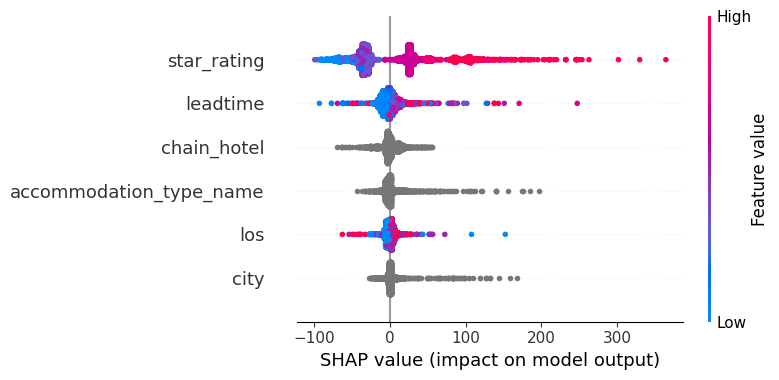

In [ ]:
shap.summary_plot(shap_values, X_test, feature_names=features)

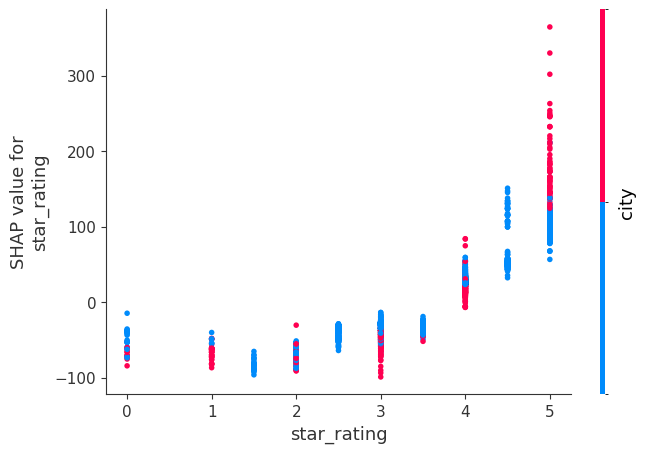

In [ ]:
shap.dependence_plot("star_rating", shap_values, X_test, feature_names=features)

# Starting over with Spark Entirely

In [ ]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, to_date, datediff
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import GBTRegressor
from pyspark.ml.evaluation import RegressionEvaluator

In [ ]:
data.show(5)

+---+-------+--------+-----------+-----------------------+-----------+-------------------+-------------------+-------------------+----+--------+---+
|  #|ADR_USD|hotel_id|star_rating|accommodation_type_name|chain_hotel|       booking_date|       checkin_date|      checkout_date|city|leadtime|los|
+---+-------+--------+-----------+-----------------------+-----------+-------------------+-------------------+-------------------+----+--------+---+
|  1|  71.06|  297388|        2.5|                  Hotel|  non-chain|2016-08-02 00:00:00|2016-10-01 00:00:00|2016-10-02 00:00:00|   A|      60|  1|
|  2|  76.56|  298322|        3.0|                  Hotel|  non-chain|2016-08-02 00:00:00|2016-10-01 00:00:00|2016-10-02 00:00:00|   A|      60|  1|
|  3| 153.88| 2313076|        5.0|                  Hotel|      chain|2016-08-02 00:00:00|2016-10-01 00:00:00|2016-10-02 00:00:00|   A|      60|  1|
|  4|  126.6| 2240838|        3.5|                  Hotel|  non-chain|2016-08-04 00:00:00|2016-10-02 00:00

In [ ]:
feature_columns = ["star_rating", "leadtime", "los"]
# GBTRegressor cannot handle categorical feature
assembler = VectorAssembler(inputCols=feature_columns, outputCol="features")
data_copy = assembler.transform(data)

In [ ]:
train_data, test_data = data_copy.randomSplit([0.8, 0.2], seed=42)

In [ ]:
gbt = GBTRegressor(featuresCol="features", labelCol="ADR_USD", maxIter=100)
gbt_model = gbt.fit(train_data)

In [ ]:
predictions = gbt_model.transform(test_data)

In [ ]:
evaluator_rmse = RegressionEvaluator(labelCol="ADR_USD", predictionCol="prediction", metricName="rmse")
evaluator_mae = RegressionEvaluator(labelCol="ADR_USD", predictionCol="prediction", metricName="mae")
evaluator_r2 = RegressionEvaluator(labelCol="ADR_USD", predictionCol="prediction", metricName="r2")

rmse = evaluator_rmse.evaluate(predictions)
mae = evaluator_mae.evaluate(predictions)
r2 = evaluator_r2.evaluate(predictions)

metrics_df = spark.createDataFrame([
    ("RMSE", rmse),
    ("MAE", mae),
    ("R²", r2)
], ["Metric", "Value"])

metrics_df.show()

+------+------------------+
|Metric|             Value|
+------+------------------+
|  RMSE| 66.76707515828548|
|   MAE| 34.63248262188715|
|    R²|0.3929525172701669|
+------+------------------+



# Now it's your turn!

*   For people interested in modeling
  * Think about how you can improve these models further
    * Separate model for each city?
    * Create more features, get creative (Ex: average ADR by city, proportion of chain hotels in city)
    * OneHotEncode the categorical features and try other ML algorithms (Ex: DecisionTreeRegressor)
*   For people interested in visualization
  * Dive deeper into the data: How many cities are there? How many hotels? What are the impact these can have on the model?
    * What is the average ADR in each city?
  * Try to find the relationship between leadtime and ADR
  * Analyze the feature correlation. Use heatmap.
  * Any trend in seasonality you can observe

**Please also prepare a quick presentation for sharing!**